# OHBM 2021 Educational: Tractometry: Peering into the White Matter 

<img src="Fig1.png" alt="Tractometry from Chamberland et al. 2019 Neuroimage" style="width: 800px;" align="left"/>

Based on:

1. Chamberland, M., Raven, E.P., Genc, S., Duffy, K., Descoteaux, M., Parker, G.D., Tax, C.M. and Jones, D.K., 2019. Dimensionality reduction of diffusion MRI measures for improved tractometry of the human brain. NeuroImage, 200, pp.89-100.  
2. Chamberland, M., Genc, S., Tax, C.M., Shastin, D., Koller, K., Raven, E.P., Parker, G.D., Hamandi, K., Gray, W.P. and Jones, D.K., 2021. Detecting microstructural deviations in individuals with deep diffusion MRI tractometry. medRxiv.

Author: **Maxime Chamberland**  
Website: [chamberm.github.io](https://chamberm.github.io)
---

## Load libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import umap
from sklearn.decomposition import PCA
from sklearn import preprocessing

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import keras
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Dense, Input
from keras.optimizers import Adam

Using TensorFlow backend.


# Dimensionality reduction
Goal: represent **m**-dimensional data in **n**-dimensional space, where **m** > **n**

In [2]:
data = pd.read_csv("example-means.csv")

In [3]:
data.shape

(792, 10)

In [4]:
data.columns

Index(['ID', 'bundle', 'FA', 'AD', 'RD', 'MD', 'AFD', 'NuFO', 'AFDtot', 'FR'], dtype='object')

In [5]:
data

,ID,bundle,FA,AD,RD,MD,AFD,NuFO,AFDtot,FR
0,S01,AC,0.473108,0.000816,0.000573,0.000805,0.471106,1.306290,0.226528,0.213662
1,S02,AC,0.392174,0.000790,0.000634,0.000818,0.331104,1.244027,0.181709,0.150192
2,S03,AC,0.408891,0.000747,0.000624,0.000820,0.387026,1.413901,0.200184,0.178396
3,S04,AC,0.511106,0.000847,0.000524,0.000775,0.505884,1.353820,0.246757,0.271486
4,S05,AC,0.540069,0.000851,0.000501,0.000767,0.467467,1.289840,0.250944,0.267288
...,...,...,...,...,...,...,...,...,...,...
787,S32,splenium,0.639089,0.000970,0.000400,0.000743,0.613324,1.223774,0.267203,0.359647
788,S33,splenium,0.635722,0.000985,0.000427,0.000777,0.497566,1.266794,0.238800,0.336812
789,S34,splenium,0.575856,0.000935,0.000481,0.000799,0.500401,1.275713,0.229704,0.376179
790,S35,splenium,0.613290,0.000913,0.000427,0.000751,0.553269,1.255603,0.247665,0.321732


## Here we select only a subset of the tracts for better visualization

In [6]:
df = data[data["bundle"].isin(['CST_R', 'UF_R', 'AF_R', 'splenium', 'genu', 'OR_R'])]
df_drop = df.drop(['bundle', 'ID'], axis=1)

In [7]:
df_drop

,FA,AD,RD,MD,AFD,NuFO,AFDtot,FR
72,0.460571,0.000771,0.000537,0.000743,0.462463,1.664673,0.235649,0.250477
73,0.446059,0.000709,0.000518,0.000702,0.410215,1.972680,0.250609,0.261139
74,0.456426,0.000720,0.000521,0.000711,0.438866,1.768396,0.247017,0.271555
75,0.459620,0.000721,0.000512,0.000703,0.444296,1.915606,0.252838,0.287181
76,0.481115,0.000734,0.000482,0.000685,0.529146,1.777858,0.270847,0.312424
...,...,...,...,...,...,...,...,...
787,0.639089,0.000970,0.000400,0.000743,0.613324,1.223774,0.267203,0.359647
788,0.635722,0.000985,0.000427,0.000777,0.497566,1.266794,0.238800,0.336812
789,0.575856,0.000935,0.000481,0.000799,0.500401,1.275713,0.229704,0.376179
790,0.613290,0.000913,0.000427,0.000751,0.553269,1.255603,0.247665,0.321732


## Look at the correlation between the features

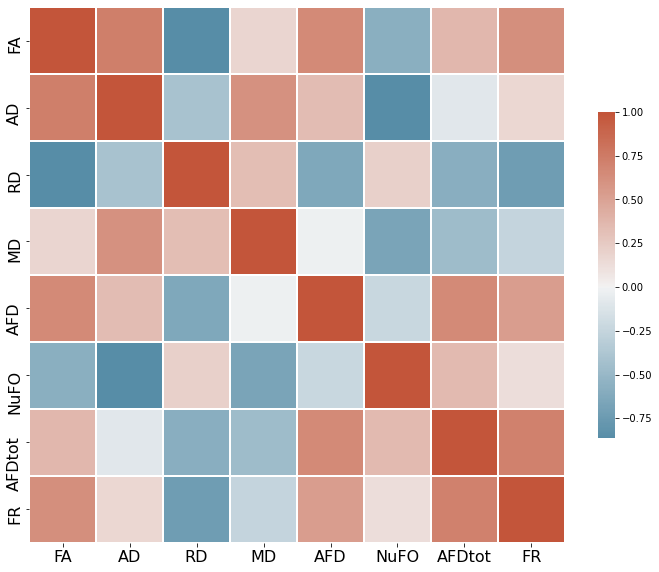

In [8]:
fig, ax = plt.subplots(1,1,figsize=(12, 12))
corr = df_drop.corr()
cmap = sns.diverging_palette(230, 20, as_cmap=True)
ax = sns.heatmap(corr, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
ax.tick_params(labelsize=16)

## Scale the data

In [9]:
scaler = preprocessing.StandardScaler().fit(df_drop)
df_scaled = scaler.transform(df_drop)

# 1. Principal Component Analysis (PCA)

In [10]:
pca = PCA(n_components=2, random_state=42)
pc = pca.fit(df_scaled)

In [11]:
pc.explained_variance_ratio_

array([0.48115804, 0.34884104])

- In other words, PC1 explains 48% of the variance in the data, and PC2 captures 35% of the variance

In [12]:
pc.components_.T

array([[ 0.48157738, -0.13852016],
       [ 0.31247222, -0.43831452],
       [-0.45982106, -0.12661752],
       [ 0.00302258, -0.52097771],
       [ 0.4119973 ,  0.07126228],
       [-0.20466856,  0.51987692],
       [ 0.31206471,  0.40059119],
       [ 0.38727823,  0.25577167]])

- The 2 columns show the contribution of the features to PC1 and PC2 respectively. 
1. Metrics like FA, AD, RD, AFD, AFD_tot and FR contribute to **PC1**: PC1 captures the tissue restriction
2. Metrics like AD, MD, NuFO contribute to **PC2**: PC2 captures the tissue complexity

In [13]:
comp = pc.transform(df_scaled)

Text(0.5, 1.0, 'PCA')

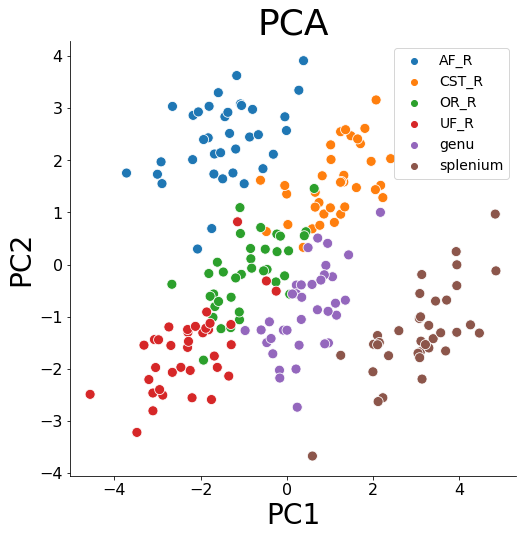

In [14]:
fig, ax = plt.subplots(1,1,figsize=(8, 8))
ax = sns.scatterplot(x=comp[:, 0], y=comp[:, 1], hue=df.bundle.tolist(), s=100)
ax.tick_params(labelsize=16)
sns.despine()
plt.legend(fontsize=14)
ax.set_xlabel("PC1",size=28)
ax.set_ylabel("PC2",size=28)
ax.set_title("PCA", size=36)

#### Bundle projections based on PC1 and PC2. The horizontal axis shows a restriction or hindrance component. Each point wihtin a cluster represents one subject. 
- On the right-most part of this axis are located densely-packed bundles such as the CST (orange), genu (purple) and splenium (brown). The vertical axis represents the complexity degree of bundles. 
- On top of this axis is the arcuate fasciculus (blue), a pathways which is known to have many crossing regions. 

# 2. Deep Autoencoder

In [15]:
scaler = preprocessing.MinMaxScaler().fit(df_drop)
df_scaled = scaler.transform(df_drop)
df_scaled.shape

(216, 8)

## We train an Autoencoder with 2 neurons in the bottleneck layer using linear activations (i.e., similar to PCA)

Instructions for updating:
Colocations handled automatically by placer.
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 18        
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 24        
Total params: 42
Trainable params: 42
Non-trainable params: 0
_________________________________________________________________
None
Instructions for updating:
Use tf.cast instead.


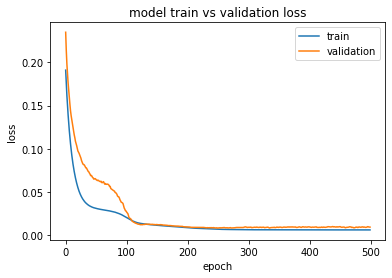

In [16]:
## Code from https://towardsdatascience.com/pca-vs-autoencoders-1ba08362f450
input_dimLin = df_scaled.shape[1]
encoding_dimLin = 2  
input_dataLin = Input(shape=(input_dimLin,))
encodedLin = Dense(encoding_dimLin, activation='linear')(input_dataLin)
decodedLin = Dense(input_dimLin, activation='linear')(encodedLin)
autoencoderLin = Model(input_dataLin, decodedLin)
autoencoderLin.compile(optimizer='adam', loss='mse')
print(autoencoderLin.summary())

historyLin = autoencoderLin.fit(df_scaled, df_scaled,
                epochs=500,
                batch_size=16,
                shuffle=True,
                validation_split=0.1,
                verbose = 0)

#plot the loss 
plt.plot(historyLin.history['loss'])
plt.plot(historyLin.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

# use the encoded layer to encode the data
encoderLin = Model(input_dataLin, encodedLin)
encoded_inputLin = Input(shape=(encoding_dimLin,))
decoder_layerLin = autoencoderLin.layers[-1]
decoderLin = Model(encoded_inputLin, decoder_layerLin(encoded_inputLin))
encoded_dataLin = encoderLin.predict(df_scaled)

## We train an Autoencoder with 2 neurons in the bottleneck layer using ReLU activations (i.e. non-linear)

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 8)                 0         
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 18        
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 24        
Total params: 42
Trainable params: 42
Non-trainable params: 0
_________________________________________________________________
None


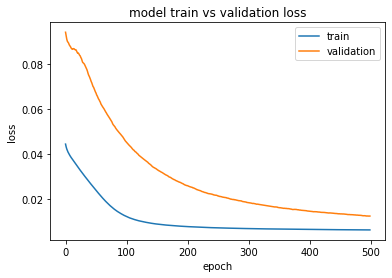

In [21]:
input_dim = df_scaled.shape[1]
encoding_dim = 2  
input_data = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation='relu')(input_data)
decoded = Dense(input_dim, activation='sigmoid')(encoded)
autoencoder = Model(input_data, decoded)
autoencoder.compile(optimizer='adam', loss='mse')
print(autoencoder.summary())

history = autoencoder.fit(df_scaled, df_scaled,
                epochs=500,
                batch_size=16,
                shuffle=True,
                validation_split=0.1,
                verbose = 0)

#plot the loss 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

# use the encoded layer to encode the data
encoder = Model(input_data, encoded)
encoded_input = Input(shape=(encoding_dim,))
decoder_layer = autoencoder.layers[-1]
decoder = Model(encoded_input, decoder_layer(encoded_input))
encoded_data = encoder.predict(df_scaled)

No handles with labels found to put in legend.


Text(0.5, 1.0, 'Autoencoder Relu')

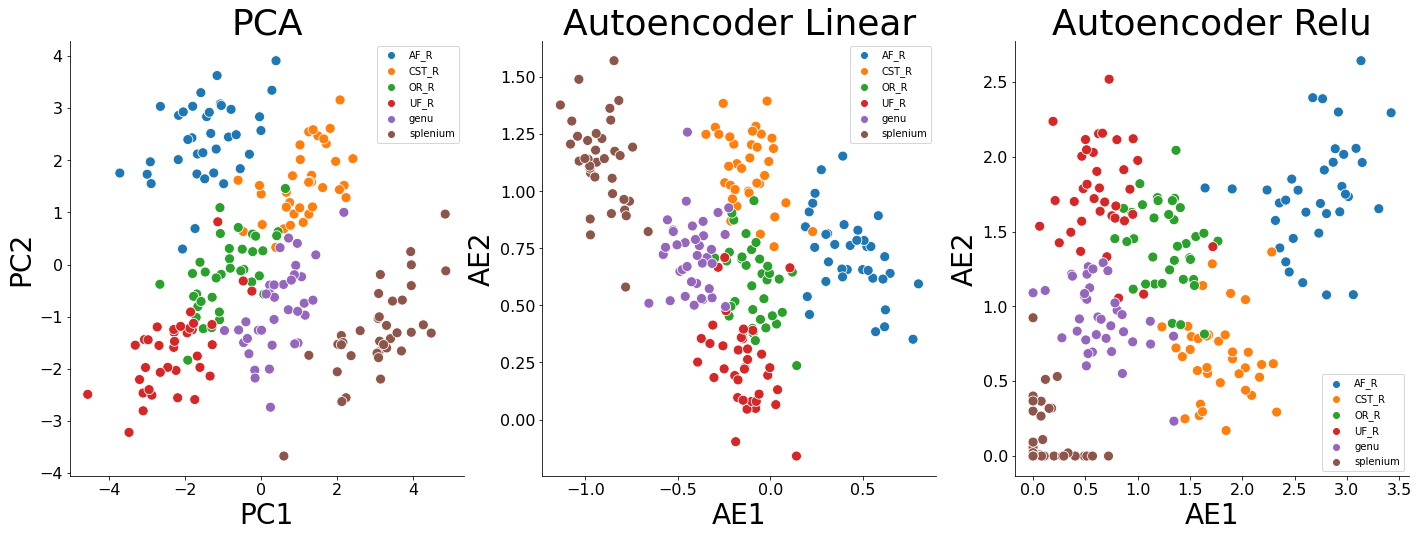

In [22]:
fig, ax = plt.subplots(1,3,figsize=(24, 8))
sns.despine()
plt.legend(fontsize=14)

sns.scatterplot(x=comp[:, 0], y=comp[:, 1], hue=df.bundle.tolist(), s=100, ax=ax[0])
ax[0].tick_params(labelsize=16)
ax[0].set_xlabel("PC1",size=28)
ax[0].set_ylabel("PC2",size=28)
ax[0].set_title("PCA", size=36)

sns.scatterplot(x=encoded_dataLin[:, 0], y=encoded_dataLin[:, 1], hue=df.bundle.tolist(), s=100, ax=ax[1])
ax[1].tick_params(labelsize=16)
ax[1].set_xlabel("AE1",size=28)
ax[1].set_ylabel("AE2",size=28)
ax[1].set_title("Autoencoder Linear", size=36)

sns.scatterplot(x=encoded_data[:, 0], y=encoded_data[:, 1], hue=df.bundle.tolist(), s=100, ax=ax[2])
ax[2].tick_params(labelsize=16)
ax[2].set_xlabel("AE1",size=28)
ax[2].set_ylabel("AE2",size=28)
ax[2].set_title("Autoencoder Relu", size=36)

**PCA**  
+ +Fast
+ +No parameter tuning
+ +Outputs transformation
+ +The output space is meaningful
- -Linear

**Autoencoder**
+ +Non-linear
- -Require lots of tuning

#  Uniform Manifold Approximation and Projection (UMAP)

In [19]:
reducer = umap.UMAP(random_state=42)
reducer.fit(df_scaled)
embedding = reducer.transform(df_scaled)

reducer3D = umap.UMAP(random_state=42, n_components=3)
reducer3D.fit(df_scaled)
embedding3D = reducer3D.transform(df_scaled)

C:\Users\max_6\Anaconda3\envs\detect\lib\site-packages\numba\np\ufunc\parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 11004. The TBB threading layer is disabled.
  warnings.warn(problem)


Text(0.5, 1.0, 'UMAP')

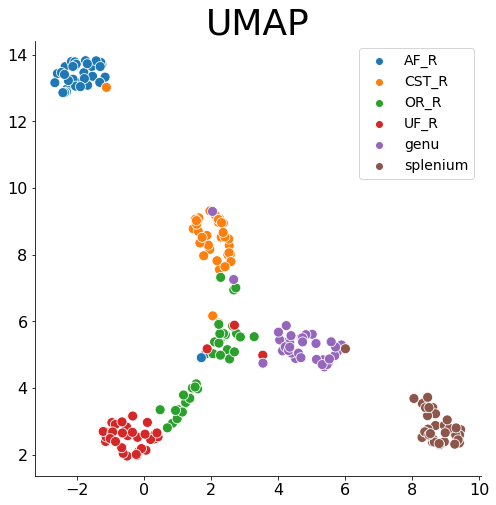

In [20]:
fig, ax = plt.subplots(1,1,figsize=(8, 8))
ax = sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], hue=df.bundle.tolist(), s=100)
ax.tick_params(labelsize=16)
sns.despine()
plt.legend(fontsize=14)
ax.set_title("UMAP", size=36)

**UMAP**
- +Scales well
- -Slower than PCA
- -Care with interpreting distances in the latent space